In [275]:
!pip3 install pmdarima

In [276]:
# Import package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


warnings.simplefilter('ignore')

In [277]:
data = pd.read_csv('Dataset3_nasdaq_1985_2014.csv',names = ['nasdaq_1985_2014'])


**Applying KPSS and ADF test**

1. ADF test

In [278]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(atr):
    #Perform Dickey-Fuller test:
    timeseries = data[atr].dropna()
    print ('Results of Dickey-Fuller Test for ',atr,'\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test('nasdaq_1985_2014')

Results of Dickey-Fuller Test for  nasdaq_1985_2014 

Test Statistic                   -2.381102
p-value                           0.147141
#Lags Used                       35.000000
Number of Observations Used    7240.000000
Critical Value (1%)              -3.431254
Critical Value (5%)              -2.861939
Critical Value (10%)             -2.566983
dtype: float64


2. KPSS test

In [279]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(atr):
    timeseries = data[atr].dropna()
    print ('Results of KPSS Test for ',atr)
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test('nasdaq_1985_2014')

Results of KPSS Test for  nasdaq_1985_2014
Test Statistic           12.143812
p-value                   0.010000
Lags Used                36.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


For ADF test, we can see that the p-value  is more than 0.05. Thus, from ADF test, we can say that the dataset is non-stationary.

For KPSS test, Test Statistic is more than Critical Value, thus we reject the null hypothesis. Thus, from KPSS test, we can say that the dataset is non-stationary.

Since, both tests conclude that the series is stationary, therefore, the dataset is concluded as Non-Stationary.



---



Making dataset stationary with differencing


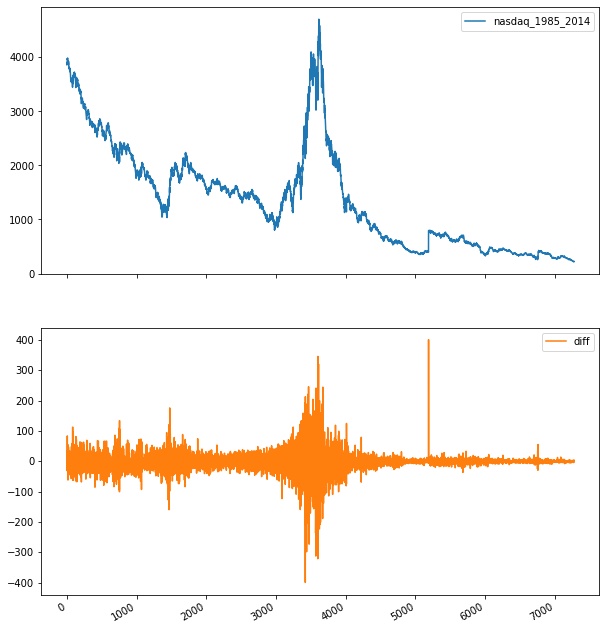

In [280]:
# Differencing
data['diff'] = data['nasdaq_1985_2014'].diff(periods=1)

data.plot(subplots=True, figsize=(10,12))
plt.show()



---



Applying Exponential Smoothening

In [281]:
#List of least mse and mae
mseses=[]
msedes=[]
msetes=[]
maeses=[]
maedes=[]
maetes=[]

**Single Exponential Smoothing**

In [282]:
#Defining Single Exponential Smoothing function ses
def ses(arr,alpha):
    arr1 = [arr[0]]
    for i in range(1, len(arr)):
        arr1.append(alpha * arr[i-1] + (1 - alpha) * arr1[i-1])
    return arr1

In [283]:
#Defining Mean of Squared Error Function mse
def mse(arr1,arr2):
  arr3=[0]
  for i, j in zip(arr1, arr2):
    arr3.append(i-j)
  Sum=0
  for i in arr3:
    sqr=i**2
    Sum+=sqr
  mse=Sum/(len(arr2)-1)
  return mse

In [284]:
#Function to make list of demand with interval 'n'
def dem_n(arr,n):
  arr1=[arr[0]]
  for i in range(1,len(arr)):
    if i%n==0:  
      arr1.append(arr[i])
  return arr1

In [285]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [286]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [287]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  2472.741440084606
Mean of Square Errors for alpha = 0.5 is:  1336.440186179414
Mean of Square Errors for alpha = 0.8 is:  1117.7909898783196


In [288]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8 is: ",mae3)

Mean Absolute Errors for alpha = 0.2 is:  28.000982741860746
Mean Absolute Errors for alpha = 0.5 is:  19.850599625184778
Mean Absolute Errors for alpha = 0.8 is:  17.774120514236166


alpha:  0.8


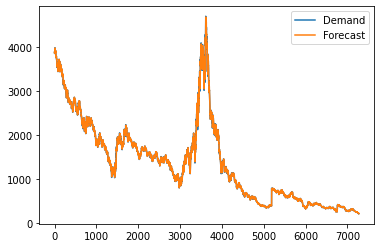

In [289]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])


**Double Exponential Smoothing**

In [290]:
#Defining Double Exponential Smoothing function des
def des(arr,alpha,beta):
  a=[arr[0]]
  l=len(arr)
  b=[(arr[l-1]-arr[0])/(l-1)]
  arr1 = [arr[0]]
  arr1.append(a[0]+b[0])
  for i in range(1,len(arr)-1):
      a.append(alpha * arr[i] + (1 - alpha) * (a[i-1]+b[i-1]))
      b.append(beta * (a[i]-a[i-1]) + (1 - beta) * (b[i-1]))        
      arr1.append(a[i]+b[i])
  return arr1

In [291]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [292]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [293]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  2536.946969983234
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1610.849168270192
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  1730.2882602330976


In [294]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3 is:  27.818256325155097
Mean Absolute Errors for alpha = 0.5,beta= 0.6 is:  21.526120724184242
Mean Absolute Errors for alpha = 0.8,beta= 0.9 is:  21.86028543903852


alpha:  0.5
beta:  0.6


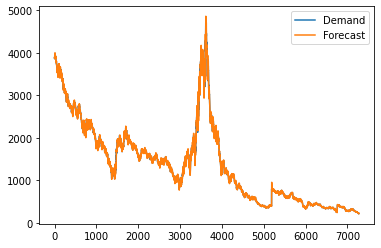

In [295]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])

**Triple Exponential Smoothing**

In [296]:
#Defining initial trend
def initial_trend(arr, slen):
    Sum = 0
    for i in range(slen):
        Sum += float(arr[i+slen] - arr[i]) / slen
    return Sum / slen

In [297]:
#Defining initial seasonal
def initial_seasonal(arr, slen):
    arr1 = {}
    s_avg = []
    m = int(len(arr)/slen)
    for j in range(m):
        s_avg.append(sum(arr[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        Sum = 0
        for j in range(m):
            Sum += arr[slen*j+i]-s_avg[j]
        arr1[i] = Sum/m
    return arr1

In [298]:
#Defining Triple Exponential Smoothing function tes with interval 'n'
def tes(arr, slen, alpha, beta, gamma, n):
    arr1 = []
    seasonals = initial_seasonal(arr, slen)
    for i in range(len(arr)+n):
        if i == 0:
            smooth = arr[0]
            trend = initial_trend(arr, slen)
            arr1.append(arr[0])
            continue
        if i >= len(arr):
            m = i - len(arr) + 1
            arr1.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = arr[i]
            lsmooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-lsmooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            arr1.append(smooth+trend+seasonals[i%slen])
    return arr1

In [299]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [300]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [301]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  324.98461283387843
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  159.5560160348016
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  584.5190867801982


In [302]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  9.812028958449401
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  7.130769745696372
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  12.927075494158293


alpha:  0.5
beta:  0.6
gamma:  0.7


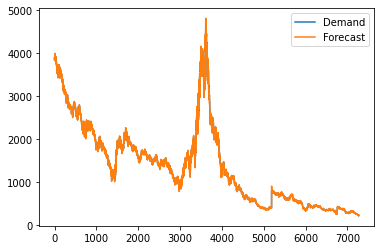

In [303]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])



---



For 1 Unit

**Single Exponential Smoothing**

In [304]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [305]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [306]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  2472.741440084606
Mean of Square Errors for alpha = 0.5 is:  1336.440186179414
Mean of Square Errors for alpha = 0.8 is:  1117.7909898783196


alpha:  0.8


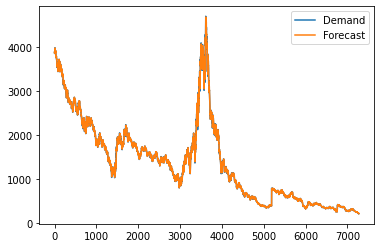

In [307]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [308]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [309]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [310]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [311]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  2536.946969983234
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  1610.849168270192
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  1730.2882602330976


alpha:  0.5
beta:  0.6


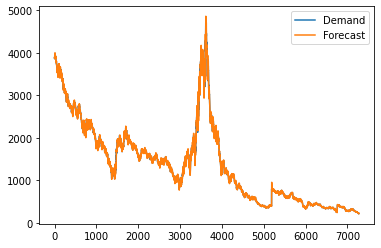

In [312]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [313]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [314]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,1)

In [315]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [316]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  324.98461283387843
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  159.5560160348016
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  584.5190867801982


In [317]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  9.812028958449401
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  7.130769745696372
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  12.927075494158293


alpha:  0.5
beta:  0.6
gamma:  0.7


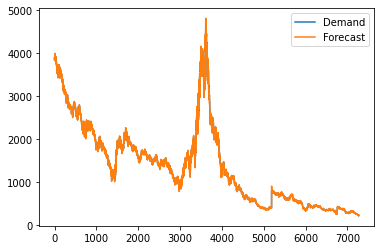

In [318]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [319]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 2 Unit

**Single Exponential Smoothing**

In [320]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,2)

In [321]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [322]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  4853.103732434068
Mean of Square Errors for alpha = 0.5 is:  2458.2670288633058
Mean of Square Errors for alpha = 0.8 is:  2061.186342147135


alpha:  0.8


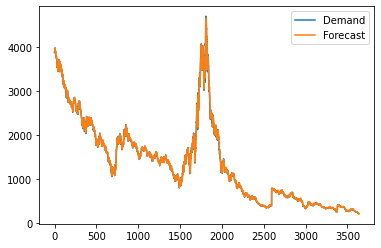

In [323]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [324]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [325]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,2)

In [326]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [327]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  4470.512808464085
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  2844.2289410307126
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  3182.6378222035564


alpha:  0.5
beta:  0.6


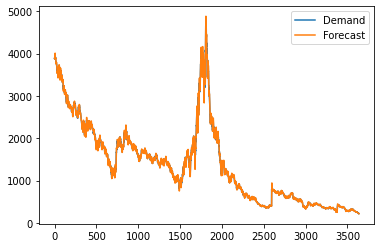

In [328]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [329]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [330]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,2)

In [331]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [332]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  594.8463666539786
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  297.6694292157872
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  1072.0211757567604


In [333]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  13.574281218977394
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  9.916028550010301
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  18.06301492152557


alpha:  0.5
beta:  0.6
gamma:  0.7


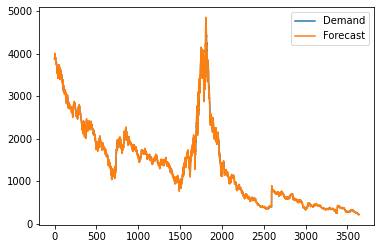

In [334]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [335]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 4 Unit

**Single Exponential Smoothing**

In [336]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,4)

In [337]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [338]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  10016.916979346734
Mean of Square Errors for alpha = 0.5 is:  4511.036145599884
Mean of Square Errors for alpha = 0.8 is:  3560.3736671460274


alpha:  0.8


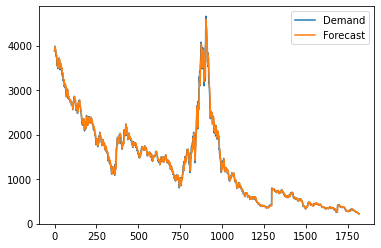

In [339]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [340]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [341]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,4)

In [342]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [343]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  9032.16360528243
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  4731.670089222
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  5163.114656800682


alpha:  0.5
beta:  0.6


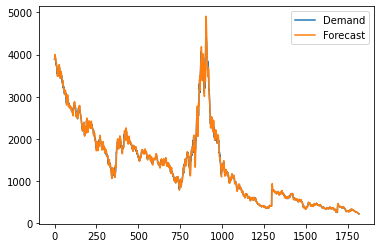

In [344]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [345]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [346]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,4)

In [347]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [348]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  1105.38559951607
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  601.9928399245516
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  1879.0043718837271


In [349]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  19.20878869799074
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  14.281490895883545
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  24.85511351923015


alpha:  0.5
beta:  0.6
gamma:  0.7


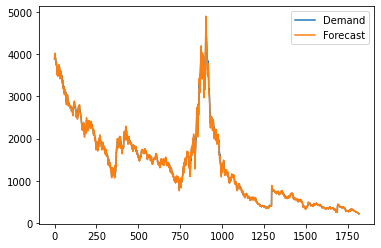

In [350]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [351]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 8 Unit

**Single Exponential Smoothing**

In [352]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,8)

In [353]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [354]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  22001.115413497686
Mean of Square Errors for alpha = 0.5 is:  9496.632863043103
Mean of Square Errors for alpha = 0.8 is:  7285.948785941906


alpha:  0.8


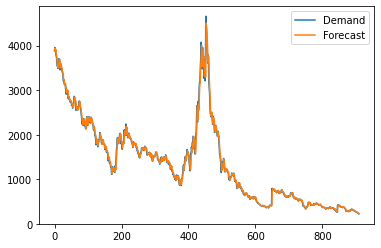

In [355]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [356]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [357]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,8)

In [358]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [359]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  18784.37734055738
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  9918.183439676426
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  10292.573461734017


alpha:  0.5
beta:  0.6


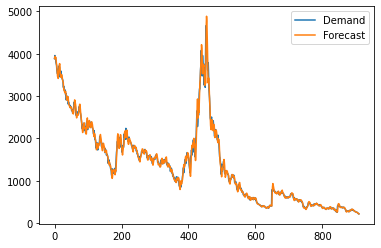

In [360]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [361]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [362]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,8)

In [363]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [364]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  2411.5017852362967
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  1315.0437876670146
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  3885.604997022788


In [365]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  28.816348734870992
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  21.113458801196593
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  35.508952118471896


alpha:  0.5
beta:  0.6
gamma:  0.7


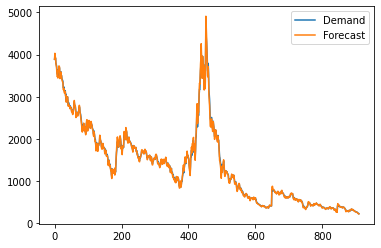

In [366]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [367]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 12 Unit

**Single Exponential Smoothing**

In [368]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,12)

In [369]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [370]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  36554.707547896985
Mean of Square Errors for alpha = 0.5 is:  15334.264016352563
Mean of Square Errors for alpha = 0.8 is:  11696.207437428884


alpha:  0.8


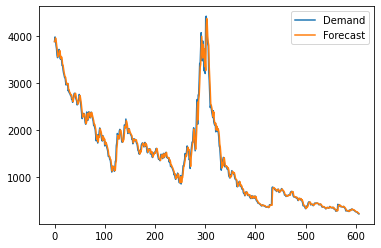

In [371]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [372]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [373]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,12)

In [374]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [375]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  27677.866788889336
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  15523.773209021978
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  16105.13520294062


alpha:  0.5
beta:  0.6


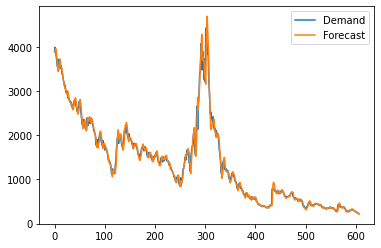

In [376]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

In [377]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maedes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maedes.append(mae2)
else:
  maedes.append(mae3)

**Triple Exponential Smoothing**

In [378]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,12)

In [379]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [380]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  4009.291152396081
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  2162.61293598704
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  6217.613679652851


In [381]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  37.25633299856909
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  27.860130011503685
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  45.02798320799283


alpha:  0.5
beta:  0.6
gamma:  0.7


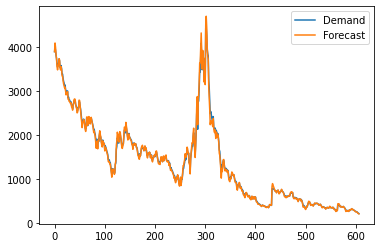

In [382]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [383]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)

For 24 Interval

**Single Exponential Smoothing**

In [384]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,24)

In [385]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

forecast1=ses(demand,alpha1)
forecast2=ses(demand,alpha2)
forecast3=ses(demand,alpha3)

In [386]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8 is: ",mse3)

Mean of Square Errors for alpha = 0.2 is:  81646.70511270332
Mean of Square Errors for alpha = 0.5 is:  33991.33138341908
Mean of Square Errors for alpha = 0.8 is:  25484.935350911685


alpha:  0.8


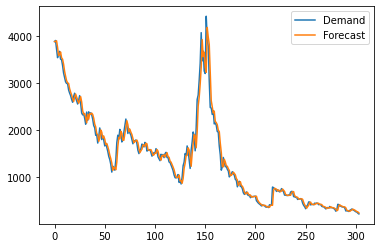

In [387]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  df1.plot(style=['-','-'])
  mseses.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  df2.plot(style=['-','-'])
  mseses.append(mse2) 
else:
  print('alpha: ',alpha3)
  df3.plot(style=['-','-'])
  mseses.append(mse3)

In [388]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maeses.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maeses.append(mae2)
else:
  maeses.append(mae3)

**Double Exponential Smoothing**

In [389]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,24)

In [390]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

forecast1=des(demand,alpha1,beta1)
forecast2=des(demand,alpha2,beta2)
forecast3=des(demand,alpha3,beta3)

In [391]:
#Calculating Mean of Square Errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 is:  67629.46120193429
Mean of Square Errors for alpha = 0.5,beta= 0.6 is:  34800.05663995416
Mean of Square Errors for alpha = 0.8,beta= 0.9 is:  34922.28877471786


alpha:  0.5
beta:  0.6


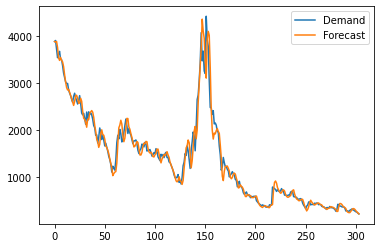

In [392]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  df1.plot(style=['-','-'])
  msedes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  df2.plot(style=['-','-'])
  msedes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  df3.plot(style=['-','-'])
  msedes.append(mse3)

**Triple Exponential Smoothing**

In [393]:
#Creating demand list in 'n' intervals
demand=dem_n(data.nasdaq_1985_2014,24)

In [394]:
#Forecasting
alpha1=0.2
alpha2=0.5
alpha3=0.8

beta1=0.3
beta2=0.6
beta3=0.9

gamma1=0.4
gamma2=0.7
gamma3=0.95

#Considering season of 1 hours here

forecast1=tes(demand,1,alpha1,beta1,gamma1,0)
forecast2=tes(demand,1,alpha2,beta2,gamma2,0)
forecast3=tes(demand,1,alpha3,beta3,gamma3,0)

In [395]:
#Calculating mean of sqaured errors
mse1=mean_squared_error(demand,forecast1)
mse2=mean_squared_error(demand,forecast2)
mse3=mean_squared_error(demand,forecast3)

print("Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is: ",mse1)
print("Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is: ",mse2)
print("Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is: ",mse3)

Mean of Square Errors for alpha = 0.2,beta= 0.3 gamma=0.4 is:  8382.365317435291
Mean of Square Errors for alpha = 0.5,beta= 0.6 gamma=0.7 is:  4817.319971579469
Mean of Square Errors for alpha = 0.8,beta= 0.9 gamma=0.95 is:  13690.609282051906


In [396]:
#Calculating Mean Absolute Errors
mae1=mean_absolute_error(demand,forecast1)
mae2=mean_absolute_error(demand,forecast2)
mae3=mean_absolute_error(demand,forecast3)

print("Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is: ",mae1)
print("Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is: ",mae2)
print("Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is: ",mae3)

Mean Absolute Errors for alpha = 0.2,beta= 0.3, gamma=0.4 is:  54.238860420695346
Mean Absolute Errors for alpha = 0.5,beta= 0.6, gamma=0.7 is:  42.58463728481874
Mean Absolute Errors for alpha = 0.8,beta= 0.9, gamma=0.95 is:  67.30157256856023


alpha:  0.5
beta:  0.6
gamma:  0.7


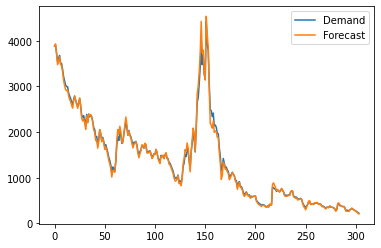

In [397]:
#Comparing mse and plotting for least mse
d1={'Demand':demand,'Forecast':forecast1}
d2={'Demand':demand,'Forecast':forecast2}
d3={'Demand':demand,'Forecast':forecast3}

df1=pd.DataFrame(d1)
df2=pd.DataFrame(d2)
df3=pd.DataFrame(d3)

if mse1<=mse2 and mse1<=mse3:
  print('alpha: ',alpha1)
  print('beta: ',beta1)
  print('gamma: ',gamma1)
  df1.plot(style=['-','-'])
  msetes.append(mse1)
elif mse2<=mse1 and mse2<=mse3:
  print('alpha: ',alpha2)
  print('beta: ',beta2)
  print('gamma: ',gamma2)
  df2.plot(style=['-','-'])
  msetes.append(mse2) 
else:
  print('alpha: ',alpha3)
  print('beta: ',beta3)
  print('gamma: ',gamma3)
  df3.plot(style=['-','-'])
  msetes.append(mse3)

In [398]:
#Storing least mae values
if mae1<=mae2 and mae1<=mae3:
  maetes.append(mae1)
elif mae2<=mae1 and mae2<=mae3:
  maetes.append(mae2)
else:
  maetes.append(mae3)



---

Least MSE and MAE values are


In [399]:
print("Least MSE ses")
print(mseses)
print("Least MSE des")
print(msedes)
print("Least MSE tes")
print(msetes)


print("Least MAE ses")
print(maeses)
print("Least MAE des")
print(maedes)
print("Least MAE tes")
print(maetes)


Least MSE ses
[1117.7909898783196, 2061.186342147135, 3560.3736671460274, 7285.948785941906, 11696.207437428884, 25484.935350911685]
Least MSE des
[1610.849168270192, 2844.2289410307126, 4731.670089222, 9918.183439676426, 15523.773209021978, 34800.05663995416]
Least MSE tes
[159.5560160348016, 297.6694292157872, 601.9928399245516, 1315.0437876670146, 2162.61293598704, 4817.319971579469]
Least MAE ses
[7.130769745696372, 7.130769745696372, 9.916028550010301, 14.281490895883545, 21.113458801196593, 27.860130011503685]
Least MAE des
[7.130769745696372, 7.130769745696372, 9.916028550010301, 14.281490895883545, 21.113458801196593]
Least MAE tes
[7.130769745696372, 9.916028550010301, 14.281490895883545, 21.113458801196593, 27.860130011503685, 42.58463728481874]




---



Applying ACF and PACF

<function matplotlib.pyplot.show>

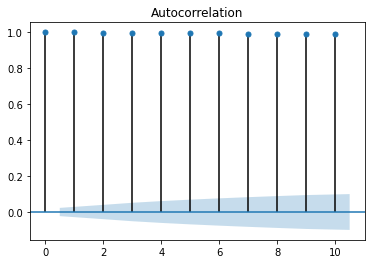

In [400]:
#Plotting ACF
plot_acf(data.nasdaq_1985_2014,lags=10)
plt.show

<function matplotlib.pyplot.show>

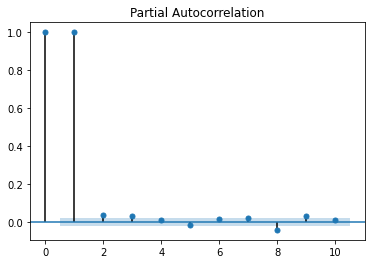

In [401]:
#plotting PACF
plot_pacf(data.nasdaq_1985_2014,lags=10)
plt.show



---



Applying AR, MA, ARIMA Models

                              ARMA Model Results                              
Dep. Variable:       nasdaq_1985_2014   No. Observations:                 7276
Model:                     ARMA(1, 0)   Log Likelihood              -35820.448
Method:                       css-mle   S.D. of innovations             33.236
Date:                Mon, 01 Mar 2021   AIC                          71646.896
Time:                        05:20:12   BIC                          71667.573
Sample:                             0   HQIC                         71654.008
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    883.2554   9045.957      0.098      0.922   -1.68e+04    1.86e+04
ar.L1.nasdaq_1985_2014     0.9998      0.002    555.560      0.000       0.996       1.003
    

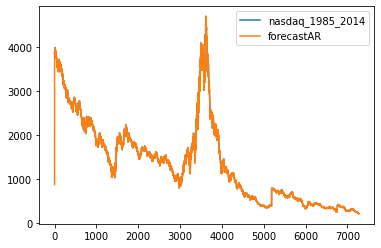

In [402]:
#AR

#fit model
model=ARIMA(data['nasdaq_1985_2014'], order=(1,0,0))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastAR'] = model_fit.predict()
data[['nasdaq_1985_2014','forecastAR']].plot()

In [403]:
mse=mean_squared_error(data.nasdaq_1985_2014,data.forecastAR.dropna())
print("MSE for AR is:",mse)

MSE for AR is: 2345.0059510285555


In [404]:
mae=mean_absolute_error(data.nasdaq_1985_2014,data.forecastAR.dropna())
print("MAE for AR is:",mae)

MAE for AR is: 17.872702594616264


                              ARMA Model Results                              
Dep. Variable:       nasdaq_1985_2014   No. Observations:                 7276
Model:                     ARMA(0, 1)   Log Likelihood              -55311.023
Method:                       css-mle   S.D. of innovations            484.294
Date:                Mon, 01 Mar 2021   AIC                         110628.046
Time:                        05:20:14   BIC                         110648.723
Sample:                             0   HQIC                        110635.157
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1375.7653     11.228    122.534      0.000    1353.760    1397.771
ma.L1.nasdaq_1985_2014     0.9777      0.002    574.513      0.000       0.974       0.981
    

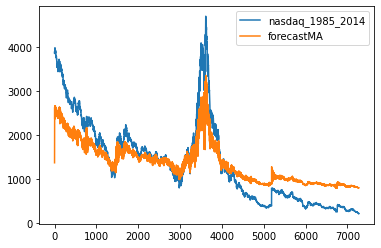

In [405]:
#MA

#fit model
model=ARIMA(data['nasdaq_1985_2014'].dropna(), order=(0,0,1))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastMA'] = model_fit.predict()
data[['nasdaq_1985_2014','forecastMA']].plot()

In [406]:
mse=mean_squared_error(data.nasdaq_1985_2014,data.forecastMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 235534.93345216895


In [407]:
mae=mean_absolute_error(data.nasdaq_1985_2014,data.forecastMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 392.66799044674684


                             ARIMA Model Results                              
Dep. Variable:                 D.diff   No. Observations:                 7274
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -35797.946
Method:                       css-mle   S.D. of innovations             33.176
Date:                Mon, 01 Mar 2021   AIC                          71603.892
Time:                        05:20:18   BIC                          71631.461
Sample:                             1   HQIC                         71613.374
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.000      0.878      0.380      -0.000       0.000
ar.L1.D.diff    -0.0591      0.012     -5.052      0.000      -0.082      -0.036
ma.L1.D.diff    -1.0000      0.000  -2208.01

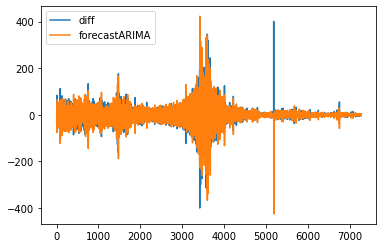

In [408]:
#ARIMA

#fit model
model=ARIMA(data['diff'].dropna(), order=(1,1,1))
model_fit=model.fit()

#model summary
print(model_fit.summary())

#make prediction
data['forecastARIMA'] = model_fit.predict()
data[['diff','forecastARIMA']].plot()

In [409]:
mse=mean_squared_error(data.nasdaq_1985_2014[0:-2],data.forecastARIMA.dropna())
print("MSE for MA is:",mse)

MSE for MA is: 2790845.8382340004


In [410]:
mae=mean_absolute_error(data.nasdaq_1985_2014[0:-2],data.forecastARIMA.dropna())
print("MAE for MA is:",mae)

MAE for MA is: 1376.2490735730798




---



Applying Auto ARIMA

In [411]:
import pmdarima as pm
model = pm.auto_arima(data.iloc[:,0], start_p=1, start_q=1,test='adf',max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0, trace=True,error_action='ignore',  suppress_warnings=True,stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=71573.519, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=71626.005, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=71602.481, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71598.884, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71625.676, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=71573.861, Time=4.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=71573.643, Time=3.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=71574.051, Time=2.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=71575.909, Time=0.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=71575.157, Time=4.78 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=71573.985, Time=0.87 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 19.657 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

# Best model:  ARIMA(1,1,1)(0,0,0)[0]



Final Result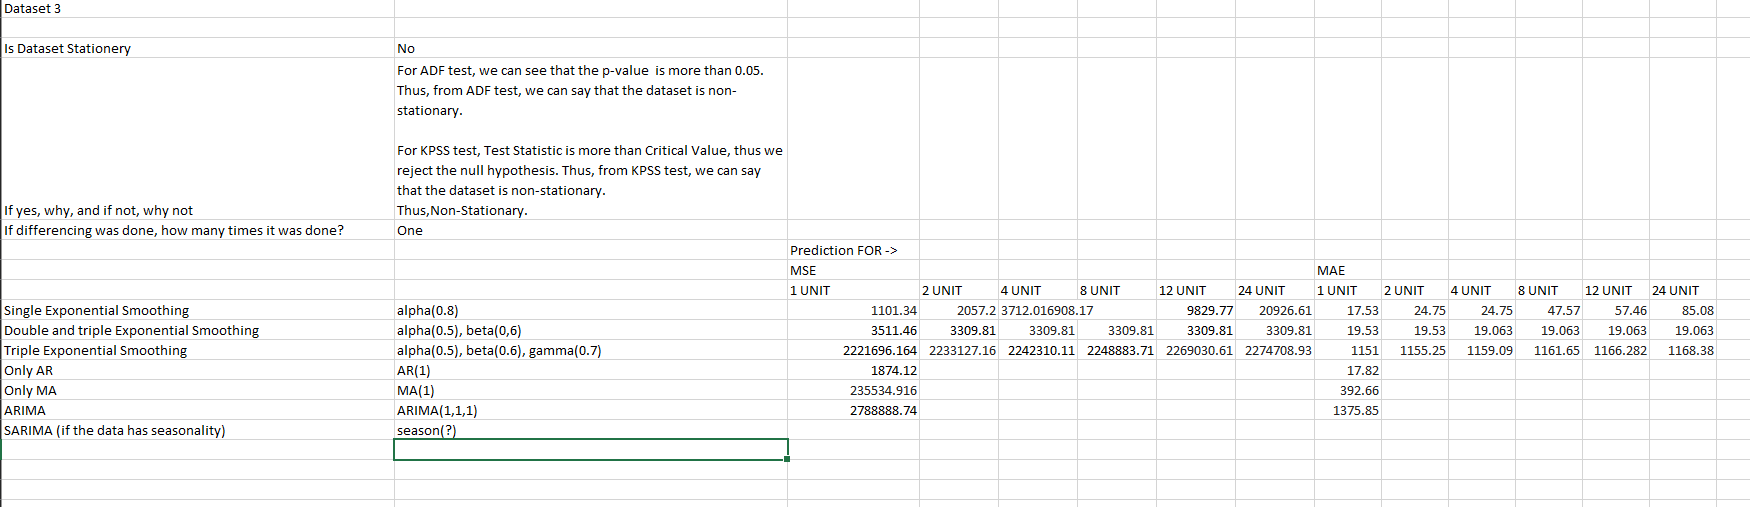